In [3]:


# !pip install yfinance statsmodels -q
!pip install matplotlib



  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 4.5 MB/s eta 0:00:004.5 MB/s eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 7.7 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 7.4 MB/s eta 0:00:007.9 MB/s eta 0:00:01
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [matplotlib] 7/8 [matplotlib]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [6]:


ticker = 'GME'
df = yf.download(ticker, start='2020-03-01', end='2025-03-01', interval='1d')
df.head()



[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GME,GME,GME,GME,GME
Date,,,,,
2020-03-02,0.9575,0.9625,0.8475,0.9000,12833600
2020-03-03,0.9075,0.9725,0.8750,0.9700,17130000
2020-03-04,0.9425,0.9575,0.8650,0.9275,17030400
2020-03-05,0.9900,0.9975,0.8975,0.9250,14397600
2020-03-06,0.9800,1.0175,0.9400,0.9600,8387200


In [7]:
df = df[['Close']]
df = df.rename(columns={'Close': 'value'})
df.index.name = 'Date'
df.head()

Price,value
Ticker,GME
Date,
2020-03-02,0.9575
2020-03-03,0.9075
2020-03-04,0.9425
2020-03-05,0.9900
2020-03-06,0.9800


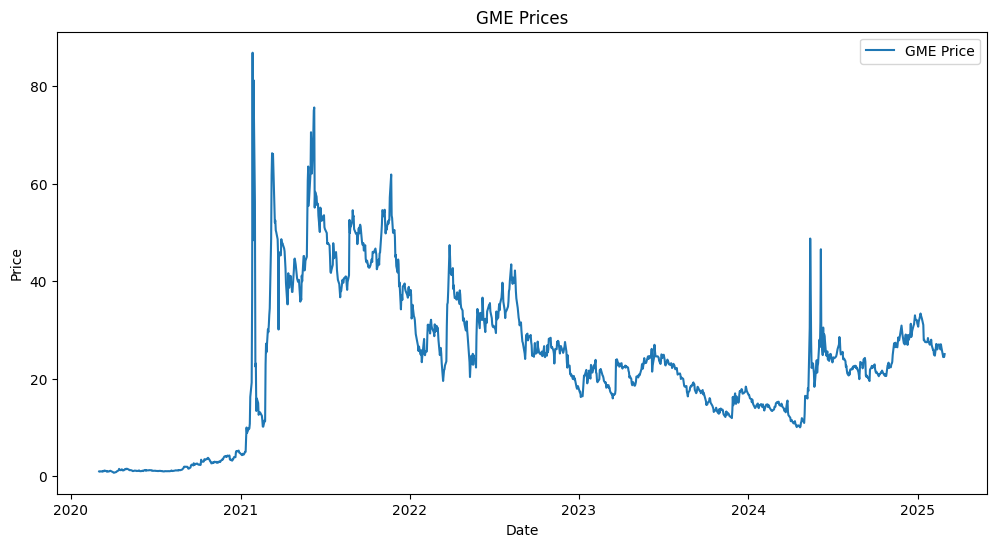

In [8]:
# plot the stock prices
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'], label='GME Price')
plt.title('GME Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [9]:


df['Z-Score'] = zscore(df['value'])

# define threshold for anomaly
threshold = 2.5
df['Anomaly Z-Score'] = df['Z-Score'].abs() > threshold



In [14]:
X = df[['value']].values

# initialize and fit isolation forest
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
df['Anomaly Isolation Forest'] = isolation_forest.fit_predict(X) == -1


In [11]:
# decompose the time series
decomposition = seasonal_decompose(df['value'], model='additive', period=30)
df['Residuals'] = decomposition.resid

# residual threshold
residual_threshold = 15
df['Anomaly Residual'] = df['Residuals'].abs() > residual_threshold

In [12]:


df.head()



Price,value,Z-Score,Anomaly Z-Score,Residuals,Anomaly Residual
Ticker,GME,,,,
Date,,,,,
2020-03-02,0.9575,-1.515425,False,NaN,False
2020-03-03,0.9075,-1.518773,False,NaN,False
2020-03-04,0.9425,-1.516429,False,NaN,False
2020-03-05,0.9900,-1.513249,False,NaN,False
2020-03-06,0.9800,-1.513919,False,NaN,False


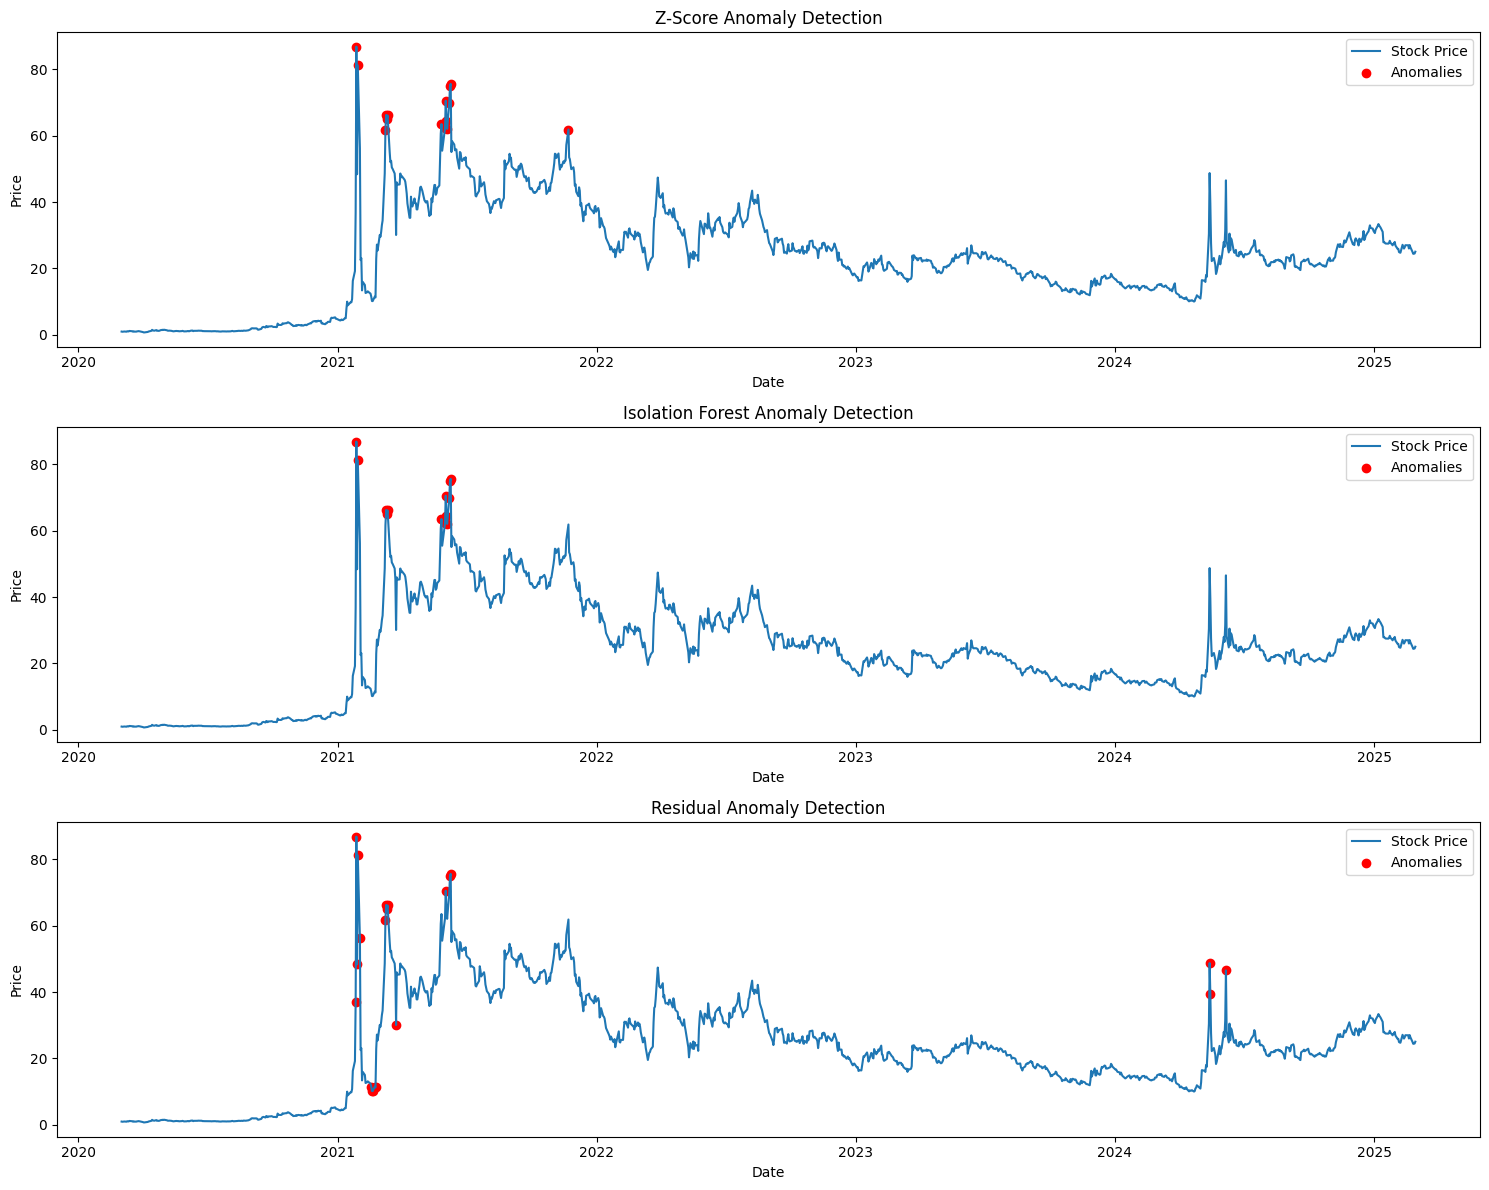

In [15]:


plt.figure(figsize=(15, 12))

# plotting z-score anomalies
plt.subplot(3, 1, 1)
plt.plot(df.index, df['value'], label='Stock Price')
plt.scatter(df.index[df['Anomaly Z-Score']], df['value'][df['Anomaly Z-Score']], color='red', label='Anomalies')
plt.title('Z-Score Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# plotting isolation forest anomalies
plt.subplot(3, 1, 2)
plt.plot(df.index, df['value'], label='Stock Price')
plt.scatter(df.index[df['Anomaly Isolation Forest']], df['value'][df['Anomaly Isolation Forest']], color='red', label='Anomalies')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# plotting residual anomalies
plt.subplot(3, 1, 3)
plt.plot(df.index, df['value'], label='Stock Price')
plt.scatter(df.index[df['Anomaly Residual']], df['value'][df['Anomaly Residual']], color='red', label='Anomalies')
plt.title('Residual Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()

